In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from google.colab import drive
import os

In [10]:
def load_data_from_drive(file_path='train1.csv'):
    """
    Load the dataset from Google Drive

    Args:
        file_path: Path to the CSV file in Google Drive (relative to My Drive root)

    Returns:
        df: Processed DataFrame
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Construct the full path (default assumes file is in the root of My Drive)
    full_path = f'/content/drive/My Drive/{file_path}'

    # Check if file exists
    if not os.path.exists(full_path):
        print(f"File not found at {full_path}")
        print("Please enter the correct path to your CSV file in Google Drive:")
        file_path = input("Path (relative to My Drive root): ")
        full_path = f'/content/drive/My Drive/{file_path}'

        if not os.path.exists(full_path):
            raise FileNotFoundError(f"File not found at {full_path}")

    # Load the dataset
    df = pd.read_csv(full_path)

    print(f"Dataset loaded successfully from Google Drive")
    print(f"Shape: {df.shape[0]} samples and {df.shape[1]} features")

    return df

In [11]:
def categorize_production(df):
    """
    Categorize production values into 5 classes using quantiles

    Args:
        df: DataFrame with production data

    Returns:
        df: DataFrame with added category column
        le: LabelEncoder object for the categories
    """
    # Define thresholds based on quantiles (20%, 40%, 60%, 80%)
    quantiles = np.quantile(df['Production (M.Ton)'], [0.2, 0.4, 0.6, 0.8])

    # Create a function to assign categories
    def assign_category(value):
        if value <= quantiles[0]:
            return 'very low'
        elif value <= quantiles[1]:
            return 'low'
        elif value <= quantiles[2]:
            return 'medium'
        elif value <= quantiles[3]:
            return 'high'
        else:
            return 'very high'

    # Apply the function to create a new column
    df['Production_Category'] = df['Production (M.Ton)'].apply(assign_category)

    # Encode the categorical target variable
    le = LabelEncoder()
    df['Production_Category_Encoded'] = le.fit_transform(df['Production_Category'])

    print("Production data categorized into 5 classes: very low, low, medium, high, very high")

    return df, le

In [12]:
def split_data(df):
    """
    Split data into train (70%), test (15%), and validation (15%) sets

    Args:
        df: DataFrame with features and target

    Returns:
        X_train_scaled, X_test_scaled, X_val_scaled: Scaled feature sets
        y_train, y_test, y_val: Target sets
        scaler: Fitted StandardScaler object
    """
    # Prepare features and target
    X = df.drop(['Production (M.Ton)', 'Production_Category', 'Production_Category_Encoded'], axis=1)
    y = df['Production_Category_Encoded']

    # Handle categorical features
    X = pd.get_dummies(X)

    # First split: 70% train, 30% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Second split: 15% test, 15% validation (50% of the temp set each)
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    print(f"Data split completed: 70% training, 15% validation, 15% testing")

    return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val, scaler


In [13]:
def build_and_train_model(X_train_scaled, y_train):
    """
    Build and train the MLP classifier

    Args:
        X_train_scaled: Scaled training features
        y_train: Training target

    Returns:
        mlp: Trained MLP classifier
    """
    print("\nBuilding and training MLP classifier...")
    mlp = MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
        activation='relu',             # ReLU activation function
        solver='adam',                 # Adam optimizer
        alpha=0.0001,                  # L2 regularization term
        batch_size='auto',             # Batch size for gradient descent
        learning_rate='adaptive',      # Adaptive learning rate
        max_iter=1000,                 # Maximum number of iterations
        random_state=42                # For reproducibility
    )

    # Train the model
    mlp.fit(X_train_scaled, y_train)

    # Print training information
    print(f"Model training completed in {mlp.n_iter_} iterations")
    print(f"Final loss: {mlp.loss_:.6f}")

    return mlp

In [14]:
def evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                  y_train, y_val, y_test, le):
    """
    Evaluate the model performance

    Args:
        mlp: Trained MLP classifier
        X_train_scaled, X_val_scaled, X_test_scaled: Scaled feature sets
        y_train, y_val, y_test: Target sets
        le: LabelEncoder for category names

    Returns:
        results: Dictionary with evaluation metrics
    """
    # Make predictions
    y_train_pred = mlp.predict(X_train_scaled)
    y_val_pred = mlp.predict(X_val_scaled)
    y_test_pred = mlp.predict(X_test_scaled)

    # Calculate evaluation metrics
    print("\nModel Evaluation Metrics:")
    print("-" * 40)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_test, y_test_pred, average='micro')
    precision_macro = precision_score(y_test, y_test_pred, average='macro')
    precision_weighted = precision_score(y_test, y_test_pred, average='weighted')

    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_test, y_test_pred, average='micro')
    recall_macro = recall_score(y_test, y_test_pred, average='macro')
    recall_weighted = recall_score(y_test, y_test_pred, average='weighted')

    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (weighted): {recall_weighted:.4f}")

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

    print(f"F1 Score (micro): {f1_micro:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)

    # Store results in a dictionary
    results = {
        'accuracy': test_accuracy,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm
    }

    return results

In [15]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix

    Args:
        cm: Confusion matrix
        class_names: Names of the classes
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

MLP Classifier for Production Data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully from Google Drive
Shape: 5120 samples and 14 features
Production data categorized into 5 classes: very low, low, medium, high, very high
Data split completed: 70% training, 15% validation, 15% testing

Building and training MLP classifier...
Model training completed in 281 iterations
Final loss: 0.005106

Model Evaluation Metrics:
----------------------------------------
Training accuracy: 0.9994
Validation accuracy: 0.8516
Test accuracy: 0.8255
Precision (micro): 0.8255
Precision (macro): 0.8273
Precision (weighted): 0.8273
Recall (micro): 0.8255
Recall (macro): 0.8256
Recall (weighted): 0.8255
F1 Score (micro): 0.8255
F1 Score (macro): 0.8262
F1 Score (weighted): 0.8261

Detailed Classification Report:
              precision    recall  f1-score   support

        high       0.76      0.80      

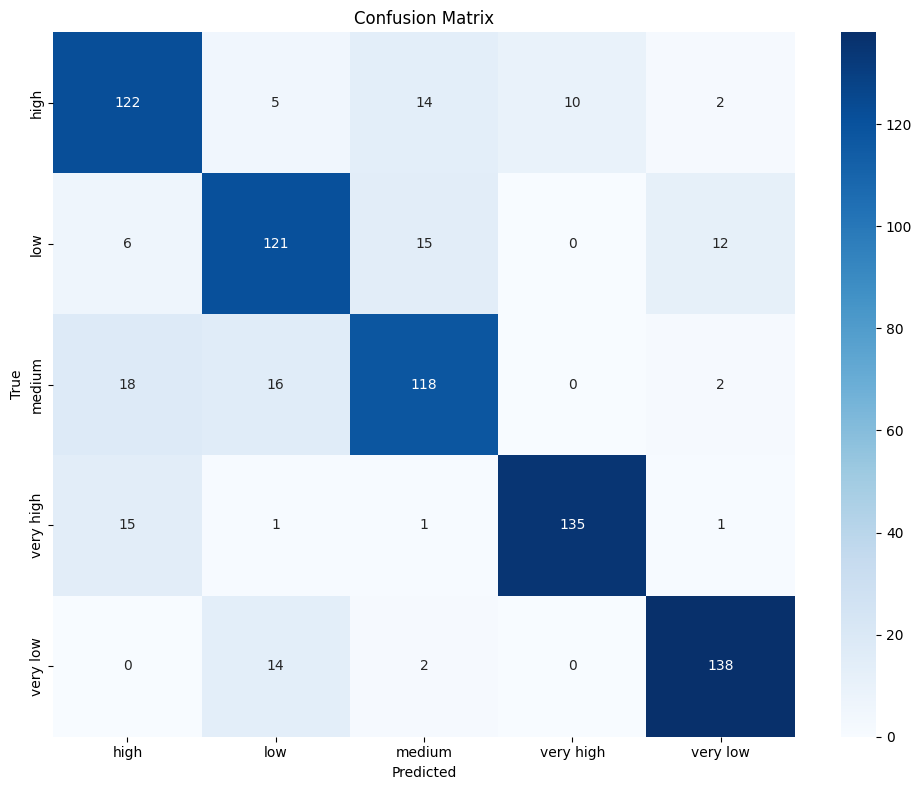


MLP Classification completed successfully!


In [18]:
print("MLP Classifier for Production Data" )
print("=" * 40)

# Step 1: Load data from Google Drive
# You can specify a different path if needed: df = load_data_from_drive('path/to/your/train1.csv')
df = load_data_from_drive()

# Step 2: Categorize production
df, le = categorize_production(df)

# Step 3: Split data
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val, scaler = split_data(df)

# Step 4: Build and train model
mlp = build_and_train_model(X_train_scaled, y_train)

# Step 5: Evaluate model
results = evaluate_model(mlp, X_train_scaled, X_val_scaled, X_test_scaled,
                        y_train, y_val, y_test, le)

# Step 6: Plot confusion matrix
plot_confusion_matrix(results['confusion_matrix'], le.classes_)

print("\nMLP Classification completed successfully!")
